In [1]:
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import os
from scipy.sparse import csr_matrix
from scipy.sparse import diags
import cv2
import pandas as pd

In [5]:
d = n = 50
r = 5
U_star = np.random.normal(0, 1, (d, r))
V_star = np.random.normal(0, 1, (n, r))
L_star = U_star.dot(V_star.T)
L_star.shape

(50, 50)

In [6]:
def create_S(p,d,n):
    s = np.zeros(d*n)

    change_list = random.sample(range(d*n),int(p*d*n))
    for i in change_list:
        s[i] = np.random.normal(0, 10)
    
    s = s.reshape(d,n)
    return s

In [7]:
def L1_norm(x):
    return np.sum(np.abs(x))

In [8]:
def fun_val(x, u, v):
    return L1_norm(x-np.dot(u, v.T))

In [9]:
def plt_converge(norm_list, xlabel, ylabel, x=None):
    if x is None:
        x = range(len(norm_list))
    sns.set(context='notebook', style='darkgrid', font_scale=1)
    plt.figure(figsize=(7,7))
    plt.plot(x, norm_list)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig('Figure.pdf')
    plt.show()

In [10]:
def A_IRLS(X, U0, V0, iter_num, plt_loss=False, plt_fun=False, L_star=None):
    
    d = U0.shape[0]
    r = U0.shape[1]
    n = V0.shape[0]
    
    norm_list = []
    fun_list = []
    
    Wu_list = np.ones((d, n))
    Wv_list = np.ones((n, d))
    
    if plt_loss:
        norm_list.append(np.linalg.norm(np.dot(U0, V0.T)-L_star, ord=2))
    if plt_fun:
        fun_list.append(L1_norm(X-np.dot(U0, V0.T)))

    Tnum = iter_num
    iteration = 0
    delta = 0.0001
    
    for iteration in tqdm(range(Tnum)):
    
        #fix U, update V
        #every column in X, treat it as a subproblem
        for i in range(X.shape[1]):
            y = X[:,i].reshape(-1,1)
            w = Wv_list[i]
            W = diags(w)
            W = csr_matrix(W)
            beta = np.linalg.solve((U0.T)@W@U0,(U0.T)@W@y)
            V0[i,:] = beta.reshape(r)
            
            tmp = np.abs(y - np.dot(U0, beta)).reshape(y.size)
            tmp[tmp<delta] = delta
            Wv_list[i] = 1/tmp
            
        #fix V, update U
        #every column in X.T, treat it as a subproblem
        for i in range(X.T.shape[1]):
            y = X.T[:,i].reshape(-1,1)
            w = Wu_list[i]
            W = diags(w)
            W = csr_matrix(W)
            beta = np.linalg.solve((V0.T)@W@V0,(V0.T)@W@y)
            U0[i,:] = beta.reshape(r)
            
            tmp = np.abs(y - np.dot(V0, beta)).reshape(y.size)
            tmp[tmp<delta] = delta
            Wu_list[i] = 1/tmp
        
        if plt_loss:
            norm_list.append(np.linalg.norm(np.dot(U0, V0.T)-L_star, ord=2))
        if plt_fun:
            fun_list.append(L1_norm(X-np.dot(U0, V0.T)))
    
    if plt_loss:
        plt_converge(norm_list, "iteration number", r"$||U_kV_k^{T}-L^{\star}||_F$")
    if plt_fun:
        plt_converge(fun_list, "iteration number", r"$||X-U_kV_k^{T}||_1$")
    
    return (U0, V0)

## Artifical dataset p1

In [11]:
p = 0.3
S_star = create_S(p, d, n)
X = L_star + S_star

In [18]:
U_0 = np.random.normal(0, 1, (d, r))
V_0 = np.random.normal(0, 1, (n, r))

100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


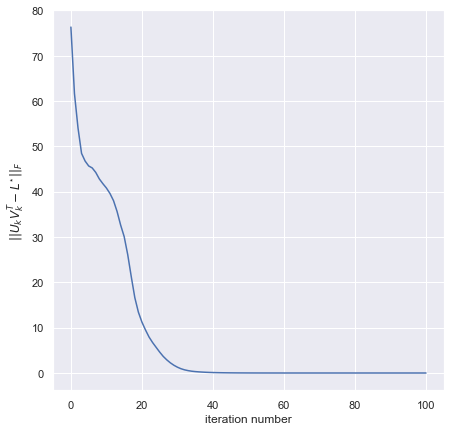

In [19]:
U_hat, V_hat = A_IRLS(X, U_0, V_0, 100, True, False, L_star)

## Artifical dataset p2

100%|██████████| 100/100 [00:04<00:00, 23.51it/s]


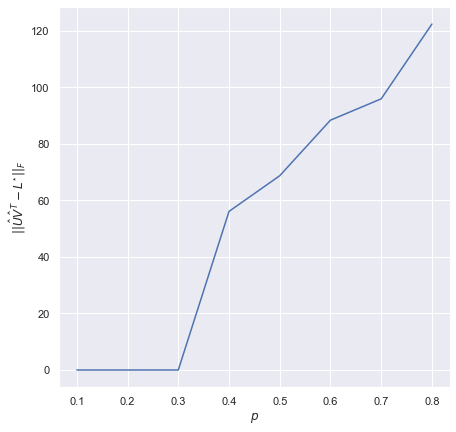

In [20]:
p_list = np.arange(1,9)*0.1
F_norm_list = []
for p in p_list:
    S_star = create_S(p, d, n)
    X = L_star + S_star
    U_0 = np.random.normal(0, 1, (d, r))
    V_0 = np.random.normal(0, 1, (n, r))
    U_hat, V_hat = A_IRLS(X, U_0, V_0, 100, False, False, L_star)
    F_norm_list.append(np.linalg.norm(np.dot(U_hat, V_hat.T)-L_star, ord=2))
    
plt_converge(F_norm_list, r'$p$', r'$||\hat{U}\hat{V}^{T}-L^{\star}||_F$', p_list)

## The Yale-B02 dataset

In [22]:
image_path = "../Data/Yale-B02/"

(192, 168)


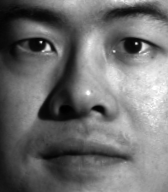

In [23]:
image_name = os.listdir(image_path)
image0 = Image.open(image_path+image_name[0])
print(np.array(image0).shape)
image0

In [24]:
image0 = np.array(image0)
n = len(image_name)
d = image0.size
r = 3

In [25]:
X = np.zeros((d, n))
for i in range(n):
    image = Image.open(image_path+image_name[i])
    image = np.array(image).reshape(d)
    X[:, i] = image
X.shape

(32256, 64)

In [26]:
U_0 = np.random.normal(0, 1, (d, r))
V_0 = np.random.normal(0, 1, (n, r))

100%|██████████| 100/100 [21:04<00:00, 12.65s/it]


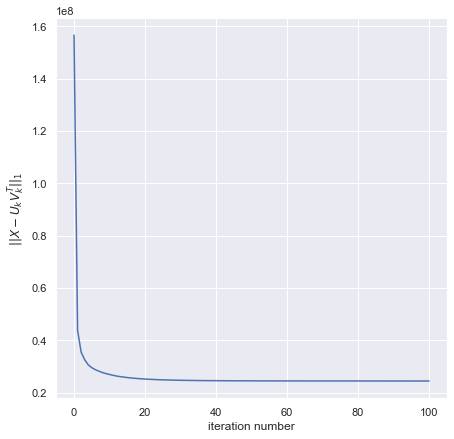

In [27]:
U_hat, V_hat = A_IRLS(X, U_0, V_0, 100, False, True)

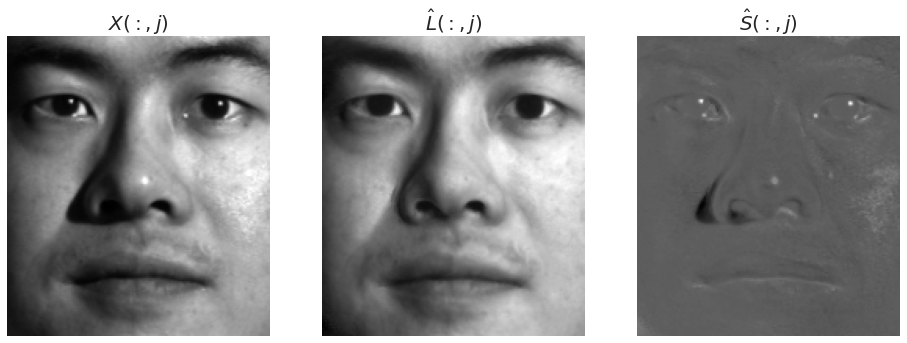

In [28]:
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(np.array(image0), cmap='gray')
plt.title(r"$X(:,j)$", size=20)
plt.axis('off')

plt.subplot(132)
New_iamge0 = np.dot(U_hat, V_hat.T)[:,0].reshape(192, 168)
plt.imshow(New_iamge0, cmap="gray")
plt.title(r"$\hat L(:,j)$", size=20)
plt.axis('off')

plt.subplot(133)
S = np.array(image0) - New_iamge0
plt.imshow(S, cmap="gray")
plt.title(r"$\hat S(:,j)$", size=20)
plt.axis('off')

plt.savefig('Figure 8.pdf')
plt.show()

## escalator video dataset

In [5]:
video_path = "../Data/"
video_row = 130
video_col = 160

In [6]:
video_df = pd.read_csv(video_path+'escalator.csv', header=None)
video_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20795,94,85,76,76,76,77,86,85,86,86,...,71,77,79,79,79,79,79,78,78,81
20796,102,88,74,73,73,74,68,70,79,79,...,69,64,63,63,64,64,70,57,57,49
20797,107,97,94,94,94,94,90,85,92,93,...,56,52,56,56,65,65,69,81,81,85
20798,143,138,123,122,123,123,128,133,130,130,...,65,47,77,77,75,75,80,103,103,101


(130, 160)


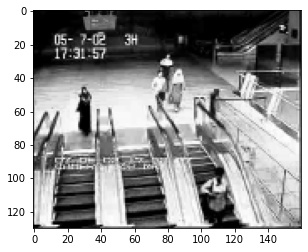

In [7]:
video0 = video_df[1].values.reshape(video_col, video_row).T
print(video0.shape)
plt.imshow(video0, cmap="gray")

In [8]:
X = video_df.values
X.shape

(20800, 200)

In [9]:
n = video_df.shape[1]
d = video0.size
r = 1

100%|██████████| 50/50 [06:58<00:00,  8.37s/it]


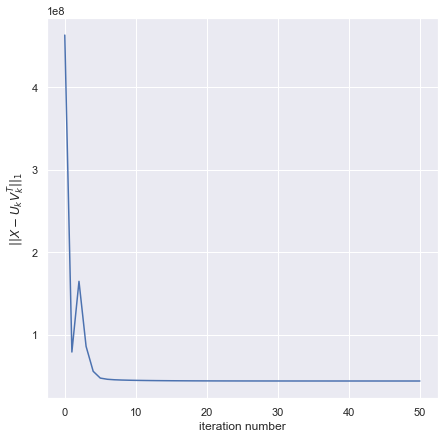

In [65]:
U_0 = np.random.normal(0, 1, (d, r))
V_0 = np.random.normal(0, 1, (n, r))
U_hat, V_hat = A_IRLS(X, U_0, V_0, 50, False, True)

In [66]:
L_hat = np.dot(U_hat, V_hat.T)
S_hat = X - L_hat

## Generate result

  0%|          | 1/200 [00:00<00:32,  6.08it/s]<ipython-input-68-0de6a6b03a27>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-68-0de6a6b03a27>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-68-0de6a6b03a27>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a n

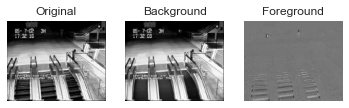

In [68]:
for i in tqdm(range(n)):
    
    plt.subplot(131)
    plt.imshow(X[:, i].reshape(video_col, video_row).T, cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(L_hat[:, i].reshape(video_col, video_row).T, cmap='gray')
    plt.title("Background")
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(S_hat[:, i].reshape(video_col, video_row).T, cmap='gray')
    plt.title("Foreground")
    plt.axis('off')
    
    plt.savefig('../result/{}.jpg'.format(i), dpi=200)

In [10]:
size = cv2.imread('../result/0.jpg').shape
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 10
videowrite = cv2.VideoWriter('result.mp4', fourcc, fps, (size[1], size[0]))
for i in tqdm(range(n)):
    video = cv2.imread('../result/{}.jpg'.format(i))
    videowrite.write(video)
videowrite.release()

100%|██████████| 200/200 [00:02<00:00, 96.69it/s]
